In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks/Empty_Shelf_Detection/'

/content/drive/My Drive/Colab Notebooks/Empty_Shelf_Detection


In [0]:
import os
import cv2
import numpy as np
import math
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.autograd.set_detect_anomaly(True)

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [4]:
'''
mobile_net = torch.hub.load('pytorch/vision:v0.5.0', 'mobilenet_v2', pretrained=True)
# _ = mobile_net.eval()
for param in mobile_net.parameters():
    param.required_grad = False

from torchsummary import summary
summary(mobile_net.to(device), (3, 512, 512))
'''

def weight_initialize(mob_net_v2, mobile_net):
    curr_bl = 0
    # phase - 1
    for i in range(len(mob_net_v2.phase_1)):
        phase_type = mob_net_v2.phase_1_type[i]
        if phase_type == 'convbnrelu':
            # order conv, bn and relu
            # conv - weight
            mob_net_v2.phase_1[i][0].weight.data.copy_(mobile_net.features[curr_bl][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_1[i][1].weight.data.copy_(mobile_net.features[curr_bl][1].weight.data)
            mob_net_v2.phase_1[i][1].bias.data.copy_(mobile_net.features[curr_bl][1].bias.data)
            mob_net_v2.phase_1[i][1].running_mean.data.copy_(mobile_net.features[curr_bl][1].running_mean.data)
            mob_net_v2.phase_1[i][1].running_var.data.copy_(mobile_net.features[curr_bl][1].running_var.data)

        if phase_type == 'inv_res_1':
            # first move to inv_res block
            # 0 is convbnrelu, 1 is conv and 2 is bn
            # order conv, bn and relu

            # 0 - convbnrelu
            # conv - weight
            mob_net_v2.phase_1[i].inv_res[0][0].weight.data.copy_(mobile_net.features[curr_bl].conv[0][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_1[i].inv_res[0][1].weight.data.copy_(mobile_net.features[curr_bl].conv[0][1].weight.data)
            mob_net_v2.phase_1[i].inv_res[0][1].bias.data.copy_(mobile_net.features[curr_bl].conv[0][1].bias.data)
            mob_net_v2.phase_1[i].inv_res[0][1].running_mean.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_mean.data)
            mob_net_v2.phase_1[i].inv_res[0][1].running_var.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_var.data)

            # 1 - conv
            mob_net_v2.phase_1[i].inv_res[1].weight.data.copy_(mobile_net.features[curr_bl].conv[1].weight.data)

            # 2 - bn
            mob_net_v2.phase_1[i].inv_res[2].weight.data.copy_(mobile_net.features[curr_bl].conv[2].weight.data)
            mob_net_v2.phase_1[i].inv_res[2].bias.data.copy_(mobile_net.features[curr_bl].conv[2].bias.data)
            mob_net_v2.phase_1[i].inv_res[2].running_mean.data.copy_(mobile_net.features[curr_bl].conv[2].running_mean.data)
            mob_net_v2.phase_1[i].inv_res[2].running_var.data.copy_(mobile_net.features[curr_bl].conv[2].running_var.data)

        if phase_type == 'inv_res_2':
            # first move to inv_res block
            # 0 is convbnrelu, 1 is convrbnrelu, 2 is conv, 3 is bn
            
            # 0 - convbnrelu
            # conv - weight
            mob_net_v2.phase_1[i].inv_res[0][0].weight.data.copy_(mobile_net.features[curr_bl].conv[0][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_1[i].inv_res[0][1].weight.data.copy_(mobile_net.features[curr_bl].conv[0][1].weight.data)
            mob_net_v2.phase_1[i].inv_res[0][1].bias.data.copy_(mobile_net.features[curr_bl].conv[0][1].bias.data)
            mob_net_v2.phase_1[i].inv_res[0][1].running_mean.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_mean.data)
            mob_net_v2.phase_1[i].inv_res[0][1].running_var.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_var.data)
            

            # 1 - convbnrelu
            # conv - weight
            mob_net_v2.phase_1[i].inv_res[1][0].weight.data.copy_(mobile_net.features[curr_bl].conv[1][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_1[i].inv_res[1][1].weight.data.copy_(mobile_net.features[curr_bl].conv[1][1].weight.data)
            mob_net_v2.phase_1[i].inv_res[1][1].bias.data.copy_(mobile_net.features[curr_bl].conv[1][1].bias.data)
            mob_net_v2.phase_1[i].inv_res[1][1].running_mean.data.copy_(mobile_net.features[curr_bl].conv[1][1].running_mean.data)
            mob_net_v2.phase_1[i].inv_res[1][1].running_var.data.copy_(mobile_net.features[curr_bl].conv[1][1].running_var.data)

            # 2 - conv
            mob_net_v2.phase_1[i].inv_res[2].weight.data.copy_(mobile_net.features[curr_bl].conv[2].weight.data)

            # 3 - bn
            mob_net_v2.phase_1[i].inv_res[3].weight.data.copy_(mobile_net.features[curr_bl].conv[3].weight.data)
            mob_net_v2.phase_1[i].inv_res[3].bias.data.copy_(mobile_net.features[curr_bl].conv[3].bias.data)
            mob_net_v2.phase_1[i].inv_res[3].running_mean.data.copy_(mobile_net.features[curr_bl].conv[3].running_mean.data)
            mob_net_v2.phase_1[i].inv_res[3].running_var.data.copy_(mobile_net.features[curr_bl].conv[3].running_var.data)
        
        curr_bl += 1

    # phase - 2 
    for i in range(len(mob_net_v2.phase_2)):

        if phase_type == 'inv_res_2':
            # first move to inv_res block
            # 0 is convbnrelu, 1 is convrbnrelu, 2 is conv, 3 is bn
            
            # 0 - convbnrelu
            # conv - weight
            mob_net_v2.phase_2[i].inv_res[0][0].weight.data.copy_(mobile_net.features[curr_bl].conv[0][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_2[i].inv_res[0][1].weight.data.copy_(mobile_net.features[curr_bl].conv[0][1].weight.data)
            mob_net_v2.phase_2[i].inv_res[0][1].bias.data.copy_(mobile_net.features[curr_bl].conv[0][1].bias.data)
            mob_net_v2.phase_2[i].inv_res[0][1].running_mean.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_mean.data)
            mob_net_v2.phase_2[i].inv_res[0][1].running_var.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_var.data)
            

            # 1 - convbnrelu
            # conv - weight
            mob_net_v2.phase_2[i].inv_res[1][0].weight.data.copy_(mobile_net.features[curr_bl].conv[1][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_2[i].inv_res[1][1].weight.data.copy_(mobile_net.features[curr_bl].conv[1][1].weight.data)
            mob_net_v2.phase_2[i].inv_res[1][1].bias.data.copy_(mobile_net.features[curr_bl].conv[1][1].bias.data)
            mob_net_v2.phase_2[i].inv_res[1][1].running_mean.data.copy_(mobile_net.features[curr_bl].conv[1][1].running_mean.data)
            mob_net_v2.phase_2[i].inv_res[1][1].running_var.data.copy_(mobile_net.features[curr_bl].conv[1][1].running_var.data)

            # 2 - conv
            mob_net_v2.phase_2[i].inv_res[2].weight.data.copy_(mobile_net.features[curr_bl].conv[2].weight.data)

            # 3 - bn
            mob_net_v2.phase_2[i].inv_res[3].weight.data.copy_(mobile_net.features[curr_bl].conv[3].weight.data)
            mob_net_v2.phase_2[i].inv_res[3].bias.data.copy_(mobile_net.features[curr_bl].conv[3].bias.data)
            mob_net_v2.phase_2[i].inv_res[3].running_mean.data.copy_(mobile_net.features[curr_bl].conv[3].running_mean.data)
            mob_net_v2.phase_2[i].inv_res[3].running_var.data.copy_(mobile_net.features[curr_bl].conv[3].running_var.data)
        
        curr_bl += 1

    # phase - 3
    for i in range(len(mob_net_v2.phase_3)):
        
        if phase_type == 'inv_res_2':
            # first move to inv_res block
            # 0 is convbnrelu, 1 is convrbnrelu, 2 is conv, 3 is bn
            
            # 0 - convbnrelu
            # conv - weight
            mob_net_v2.phase_3[i].inv_res[0][0].weight.data.copy_(mobile_net.features[curr_bl].conv[0][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_3[i].inv_res[0][1].weight.data.copy_(mobile_net.features[curr_bl].conv[0][1].weight.data)
            mob_net_v2.phase_3[i].inv_res[0][1].bias.data.copy_(mobile_net.features[curr_bl].conv[0][1].bias.data)
            mob_net_v2.phase_3[i].inv_res[0][1].running_mean.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_mean.data)
            mob_net_v2.phase_3[i].inv_res[0][1].running_var.data.copy_(mobile_net.features[curr_bl].conv[0][1].running_var.data)
            

            # 1 - convbnrelu
            # conv - weight
            mob_net_v2.phase_3[i].inv_res[1][0].weight.data.copy_(mobile_net.features[curr_bl].conv[1][0].weight.data)
            # bn - weight, bias, running_mean, running_var
            mob_net_v2.phase_3[i].inv_res[1][1].weight.data.copy_(mobile_net.features[curr_bl].conv[1][1].weight.data)
            mob_net_v2.phase_3[i].inv_res[1][1].bias.data.copy_(mobile_net.features[curr_bl].conv[1][1].bias.data)
            mob_net_v2.phase_3[i].inv_res[1][1].running_mean.data.copy_(mobile_net.features[curr_bl].conv[1][1].running_mean.data)
            mob_net_v2.phase_3[i].inv_res[1][1].running_var.data.copy_(mobile_net.features[curr_bl].conv[1][1].running_var.data)

            # 2 - conv
            mob_net_v2.phase_3[i].inv_res[2].weight.data.copy_(mobile_net.features[curr_bl].conv[2].weight.data)

            # 3 - bn
            mob_net_v2.phase_3[i].inv_res[3].weight.data.copy_(mobile_net.features[curr_bl].conv[3].weight.data)
            mob_net_v2.phase_3[i].inv_res[3].bias.data.copy_(mobile_net.features[curr_bl].conv[3].bias.data)
            mob_net_v2.phase_3[i].inv_res[3].running_mean.data.copy_(mobile_net.features[curr_bl].conv[3].running_mean.data)
            mob_net_v2.phase_3[i].inv_res[3].running_var.data.copy_(mobile_net.features[curr_bl].conv[3].running_var.data)
        
        curr_bl += 1
    
    return mob_net_v2

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_size, out_size, kernel_size, stride, padding = 0, groups = 1):
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_size, out_size, kernel_size = kernel_size, stride = stride, padding = padding, groups = groups, bias = False),
            nn.BatchNorm2d(out_size),
            nn.ReLU6(inplace = True))

class InvertedResidual_1(nn.Module):
    def __init__(self, in_filters, mid_filters, out_filters, stride = 1, groups = 1):
        super(InvertedResidual_1, self).__init__()
        layers = []
        layers.append(ConvBNReLU(mid_filters,mid_filters, 3, stride, 1, groups))
        layers.extend([nn.Conv2d(mid_filters, out_filters, 1, 1, bias = False),
                       nn.BatchNorm2d(out_filters)])
        self.inv_res = nn.Sequential(*layers)

    def forward(self, x):
        return self.inv_res(x)

class InvertedResidual_2(nn.Module):
    def __init__(self, in_filters, mid_filters, out_filters, stride = 1, groups = 1):
        super(InvertedResidual_2, self).__init__()
        self.stride = stride
        self.in_filters = in_filters
        self.out_filters = out_filters
        layers = []
        # parameters to call ConvBNReLU (in_size, out_size, kernel_size, stride, padding, groups)
        layers.append(ConvBNReLU(in_filters, mid_filters, 1, 1, 0, 1))
        layers.append(ConvBNReLU(mid_filters,mid_filters, 3, stride, 1, groups))
        layers.extend([nn.Conv2d(mid_filters, out_filters, 1, 1, bias = False),
                       nn.BatchNorm2d(out_filters)])
        self.inv_res = nn.Sequential(*layers)

    def forward(self, x):
        if self.stride == 1 and (self.in_filters == self.out_filters):
            return x + self.inv_res(x)
        else:
            return self.inv_res(x)


class Mobile_Net_V2(nn.Module):
    def __init__(self):
        super(Mobile_Net_V2, self).__init__()

        inv_res_bl = InvertedResidual_2

        self.phase_1_type = ['convbnrelu', 'inv_res_1', 'inv_res_2', 'inv_res_2',
                             'inv_res_2', 'inv_res_2', 'inv_res_2']
        p1_blocks = []
        # parameters to call ConvBNReLU (in_size, out_size, kernel_size, stride, padding, groups)
        p1_blocks.append(ConvBNReLU(3, 32, 3, 2, 1)) # 0 (-1, 32, 256, 256)
        # parameters order to call InvertedResidual (in_filters, mid_filters, out_filters, stride, groups)
        p1_blocks.append(InvertedResidual_1(32, 32, 16, 1, 32)) # 1 (-1, 16, 256, 256)
        p1_blocks.append(inv_res_bl(16, 96, 24, 2, 96)) # 2 (-1, 24, 128, 128)
        p1_blocks.append(inv_res_bl(24, 144, 24, 1, 144)) # 3 (-1, 24, 128, 128)
        p1_blocks.append(inv_res_bl(24, 144, 32, 2, 144)) # 4 (-1, 32, 64, 64)
        p1_blocks.append(inv_res_bl(32, 192, 32, 1, 192)) # 5 (-1, 32, 64, 64)
        p1_blocks.append(inv_res_bl(32, 192, 32, 1, 192)) # 6 (-1, 32, 64, 64)
        self.phase_1 = nn.Sequential(*p1_blocks)

        self.phase_2_type = ['inv_res_2', 'inv_res_2', 'inv_res_2', 'inv_res_2',
                             'inv_res_2', 'inv_res_2', 'inv_res_2']
        p2_blocks = []
        p2_blocks.append(inv_res_bl(32, 192, 64, 2, 192)) # 7 (-1, 64, 32, 32)
        p2_blocks.append(inv_res_bl(64, 384, 64, 1, 384)) # 8 (-1, 64, 32, 32)
        p2_blocks.append(inv_res_bl(64, 384, 64, 1, 384)) # 9 (-1, 64, 32, 32)
        p2_blocks.append(inv_res_bl(64, 384, 64, 1, 384)) # 10 (-1, 64, 32, 32)
        p2_blocks.append(inv_res_bl(64, 384, 96, 1, 384)) # 11 (-1, 96, 32, 32)
        p2_blocks.append(inv_res_bl(96, 576, 96, 1, 576)) # 12 (-1, 96, 32, 32)
        p2_blocks.append(inv_res_bl(96, 576, 96, 1, 576)) # 13 (-1, 96, 32, 32)
        self.phase_2 = nn.Sequential(*p2_blocks)

        self.phase_3_type = ['inv_res_2', 'inv_res_2', 'inv_res_2', 'inv_res']
        p3_blocks = []
        p3_blocks.append(inv_res_bl(96, 576, 160, 2, 576)) # 14 (-1, 160, 16, 16)
        p3_blocks.append(inv_res_bl(160, 960, 160, 1, 960)) # 15 (-1, 160, 16, 16)
        p3_blocks.append(inv_res_bl(160, 960, 160, 1, 960)) # 16 (-1, 160, 16, 16)
        p3_blocks.append(inv_res_bl(160, 960, 320, 1, 960)) # 17 (-1, 320, 16, 16)
        self.phase_3 = nn.Sequential(*p3_blocks)

    def forward(self, x):
        x_64 = self.phase_1(x)
        x_32 = self.phase_2(x_64)
        x_16 = self.phase_3(x_32)
        return [x_64, x_32, x_16]

'''
mob_net_v2 = Mobile_Net_V2().to(device)
mob_net_v2 = weight_initialize(mob_net_v2, mobile_net)
torch.save(mob_net_v2, 'mob_net_v2.pth')
'''

"\nmob_net_v2 = Mobile_Net_V2().to(device)\nmob_net_v2 = weight_initialize(mob_net_v2, mobile_net)\ntorch.save(mob_net_v2, 'mob_net_v2.pth')\n"

In [0]:
mob_net_v2 = torch.load('mob_net_v2.pth', device)
_ = mob_net_v2.eval()

In [0]:
#################################### DSSD ###################################################
# Model :                                                                                   # 
#       1.Reduce (16*16) feature maps from Mobile_net_v2 to (8*8) SSD.                      # 
#         Apply Convolution on this (8*8) to generate bounding boxes.                       #
#       2.Reduce (8*8) feature maps from SSD to (4*4).                                      #
#         Apply Convolution on this (4*4) to generate bounding boxes.                       # 
#       3.Upsample (4*4) SSD to (8*8) and do elem-prod with previous (8*8) SSD.             #            
#         Apply Convolution on this (8*8) to generate bounding boxes.                       #                                
#       4.Upsample (8*8) SSD to (16*16) and do elem-prod with (16*16) from Mobile_net_v2.   #                
#         Apply Convolution on this (16*16) to generate bounding boxes.                     #  
#       5.Upsample (16*16) SSD to (32*32) and do elem-prod with (32*32) from Mobile_net_v2. #       
#         Apply Convolution on this (32*32) to generate bounding boxes.                     #
#       6.Upsample (32*32) SSD to (64*64) and do elem-prod with (64*64) from Mobile_net_v2. #
#         Apply Convolution on this (64*64) to generate bounding boxes.                     #
#                                                                                           #
# Parameters:                                                                               #   
#       C (classes) = 2 (background and empty_space)                                        #
#       layers = 6                                                                          #        
#                                                                                           #
# Shrinkage:                                                                                #                
#       (64*64) - 8                                                                         #
#       (32*32) - 16                                                                        #    
#       (16*16) - 32                                                                        #
#       (8*8)   - 64                                                                        #        
#       (4*4)   - 128                                                                       #
#                                                                                           #
# Scales :                                                                                  #    
#       s_min = 0.2, s_max = 0.9                                                            #
#       aspect ratios = {1, 2, 3, 1/2, 1/3}                                                 #    
#                                                                                           #
# Bounding Boxes:                                                                           #
#       For feature_map size :                                                              #
#                       (64*64) - 4                                                         #            
#                       (32*32) - 4                                                         #
#                       (16*16) - 6                                                         #
#                       (8*8)   - 6                                                         #    
#                       (4*4)   - 6                                                         #
############################################################################################# 

In [6]:
class Deconvolution_Module(nn.Module):
    def __init__(self, ssd_in_filters):
        super(Deconvolution_Module, self).__init__()
        
        self.deconv = nn.ConvTranspose2d(512, 512, kernel_size = 2, stride = 2)
        self.conv_ssd = nn.Conv2d(ssd_in_filters, 512, 3, padding = 1)
    
        self.conv = nn.Conv2d(512, 512, 3, padding = 1)
        self.bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace = True)

        # upsampling Deconvolution feature maps
        self.deconv_layer = nn.Sequential(*[self.deconv, self.conv, self.bn])
        # convolutions on SSD feature maps
        self.ssd_layer = nn.Sequential(*[self.conv_ssd, self.bn, self.relu, self.conv, self.bn])

    def forward(self, deconv_features, ssd_features):
        x = self.deconv_layer(deconv_features)
        y = self.ssd_layer(ssd_features)
        return self.relu(x * y)

class DSSD(nn.Module):
    def __init__(self, base):
        super(DSSD, self).__init__()

        self.base = base
        deconv_module = Deconvolution_Module
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        # deconv_ssd(channels) 
        self.deconv_32 = deconv_module(32)
        self.deconv_96 = deconv_module(96)
        self.deconv_320 = deconv_module(320)
        self.deconv_512 = deconv_module(512)

        # predict module
        self.conv_c1024 = nn.Conv2d(512, 1024, 1)
        layers = []
        layers.append(nn.Conv2d(512, 256, 1))
        layers.append(nn.Conv2d(256, 256, 1))
        layers.append(nn.Conv2d(256, 1024, 1))
        self.predict_module = nn.Sequential(*layers)

        self.conv_16_8 = nn.Conv2d(320, 512, 3, 2, padding = 1)
        self.conv_8_4 = nn.Conv2d(512, 512, 3, 2, padding = 1)

        self.classes = 2
        self.loc, self.conf = [], []
        default_boxes = [6, 6, 6, 6, 4]
        for num_boxes in default_boxes:
            self.loc.append(nn.Conv2d(1024, 4*num_boxes, 3, padding = 1))
            self.conf.append(nn.Conv2d(1024, num_boxes, 3, padding = 1))
        self.loc = nn.ModuleList(self.loc)
        self.conf = nn.ModuleList(self.conf)

        for layer in [*self.loc, *self.conf]:
            for param in layer.parameters():
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)

    def forward(self, x):
        x_64, x_32, x_16 = self.base(x)
        # Channels in x_16_16 = 32, x_32_32 = 96, x_64_64 = 320
        x_8 = self.conv_16_8(x_16)
        p_1 = self.predict_module(x_8) + self.conv_c1024(x_8)

        x_4 = self.conv_8_4(x_8)
        p_2 = self.predict_module(x_4) + self.conv_c1024(x_4)

        # deconv_x(deconv_features, ssd_features) returns (deconv_features * 512)
        x_8 = self.deconv_512(x_4, x_8)
        p_3 = self.predict_module(x_8) + self.conv_c1024(x_8)

        x_16 = self.deconv_320(x_8, x_16)
        p_4 = self.predict_module(x_16) + self.conv_c1024(x_16)

        x_32 = self.deconv_96(x_16, x_32)
        p_5 = self.predict_module(x_32) + self.conv_c1024(x_32)

        #x_64 = self.deconv_32(x_32, x_64)
        #p_6 = self.predict_module(x_64) + self.conv_c1024(x_64)

        locs = []
        confs = []
        features_maps = [p_1, p_2, p_3, p_4, p_5]
        for ft, lc, cf in zip(features_maps, self.loc, self.conf):
            locs.append(lc(ft).view(ft.shape[0], 4, -1))
            confs.append(self.sigmoid(cf(ft)).view(ft.shape[0], 1, -1))

        locs = torch.cat(locs, 2).transpose(2, 1).contiguous()
        confs = torch.cat(confs, 2).contiguous().squeeze()
        confs[torch.isnan(confs).nonzero().squeeze()] == 0
        return locs, confs


'''
dsd = DSSD(mob_net_v2).to(device)
l, c = dssd(torch.randn(2,3,512,512).to(device))
print(l.shape, c.shape)'''

'\ndsd = DSSD(mob_net_v2).to(device)\nl, c = dssd(torch.randn(2,3,512,512).to(device))\nprint(l.shape, c.shape)'

In [7]:
from itertools import product
import math

class Default_Boxes(object):
    def __init__(self):
        super(Default_Boxes, self).__init__()

        self.img_size = 512
        self.s_min = 0.2
        self.s_max = 0.9
        self.num_boxes = [6, 6, 6, 6, 4]
        self.m = len(self.num_boxes)
        self.feature_map_dims = [8, 4, 8, 16 ,32]
        self.shrinkage = [64, 128, 64, 32, 16]
        self.aspect_ratios = [[2, 3], [2, 3], [2, 3],
                              [2, 3], [2], [2]]
        self.s_k = []
        for i in range(self.m + 1):
            s = (self.s_max - self.s_min) / (self.m - 1)
            s = self.s_min + s * (i - 0)
            self.s_k.append(s)
        
    def forward(self):
        boxes = []
        for f, fp_dim in enumerate(self.feature_map_dims):    
            for i, j in product(range(fp_dim), repeat = 2):
                f_k = self.img_size / self.shrinkage[f]
                # centers for bounding box
                c_x = (j + 0.5) / f_k
                c_y = (i + 0.5) / f_k
                # box aspect ratio = 1
                # relative size = sk
                s = self.s_k[f]
                boxes.append([c_x, c_y, s, s])

                # box aspect ratio = 1 
                # relative size = sqrt(sk * sk+1)
                s = math.sqrt(self.s_k[f]*self.s_k[f + 1])
                boxes.append([c_x, c_y, s, s])

                for ratio in self.aspect_ratios[f]:
                    s = self.s_k[f]
                    boxes.append([c_x, c_y, s*math.sqrt(ratio), s/math.sqrt(ratio)])
                    boxes.append([c_x, c_y, s/math.sqrt(ratio), s*math.sqrt(ratio)])
        
        boxes = torch.Tensor(boxes).reshape(-1, 4)
        boxes.clamp_(min = 0.0, max = 1.0)
        return boxes

'''
db = Default_Boxes().forward()
print(db.shape)
print((db < 0).nonzero())'''

'\ndb = Default_Boxes().forward()\nprint(db.shape)\nprint((db < 0).nonzero())'

In [0]:
def xcycwh_to_xyminmax(a):
    # a is in shape [N,4] - (xc, yc, w, h)
    x_min = a[:, 0] - a[:, 2]/2
    y_min = a[:, 1] - a[:, 3]/2
    x_max = a[:, 0] + a[:, 2]/2
    y_max = a[:, 1] + a[:, 3]/2
    res = torch.stack([x_min, y_min, x_max, y_max], dim = 1)
    return res.clamp(min = 0.0, max = 1.0)

def xyminmax_to_xcycwh(a):
    # a is in shape [N,4] - (xmin, ymin, xmax, ymax)
    w = a[:, 2] - a[:, 0]
    h = a[:, 3] - a[:, 1]
    xc = (a[:, 0] + a[:, 2])/2
    yc = (a[:, 1] + a[:, 3])/2
    res = torch.stack([xc, yc, h, w], dim = 1)
    return res.clamp(min = 0.0, max = 1.0)

def iou(a, b):
    # a,b in format (x_min, y_min, x_max, y_max)
    x_int_max = torch.max(a[:, 0], b[:, 0])
    y_int_max = torch.max(a[:, 1], b[:, 1])
    x_int_min = torch.min(a[:, 2], b[:, 2])
    y_int_min = torch.min(a[:, 3], b[:, 3])
    int_area = (x_int_max - x_int_min) * (y_int_max - y_int_min)
    a_area = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    b_area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    iou = (int_area) / (a_area + b_area - int_area)
    return iou

def match_boxes(gb, db, th = 0.4):
    '''
    Param:
    ------
        gb : ground truth boxes in format (xc, yc, w, h)
                        shape - (n, 4) , n = no.of boxes in image
        db : default boxes in format (xc, yc, w, h)
                        shape - (N, 4), N = no.of default boxes
    '''
    is_box_matched = torch.zeros(default_boxes.shape[0])
    box_matched_index = torch.zeros(default_boxes.shape[0])

    n = ground_boxes.shape[0]
    N = default_boxes.shape[0]
    # expand ground and default boxes feasible to apply vector operations
    #gb = gb.repeat(N, 1)
    #db = db.repeat_interleave(n, 0)
    
    #scores = iou(xcycwh_to_xyminmax(gb),
    #             xcycwh_to_xyminmax(db))
    #print(scores)

    for i in range(n):
        xc, yc, w, h = gb[i][0], gb[i][1], gb[i][2], gb[i][3]
        x1_min = xc - w/2
        y1_min = yc - h/2
        x1_max = xc + w/2
        y1_max = yc + h/2

        x1_min.clamp_(0.0, 1.0)
        y1_min.clamp_(0.0, 1.0)
        x1_max.clamp_(0.0, 1.0)
        y1_max.clamp_(0.0, 1.0)

        x2_min = db[:, 0] - db[:, 2]/2
        y2_min = db[:, 1] - db[:, 3]/2
        x2_max = db[:, 0] + db[:, 2]/2
        y2_max = db[:, 1] + db[:, 3]/2

        x2_min.clamp_(0.0, 1.0)
        y2_min.clamp_(0.0, 1.0)
        x2_max.clamp_(0.0, 1.0)
        y2_max.clamp_(0.0, 1.0)

        x_max = torch.max(x1_min, x2_min)
        y_max = torch.max(y1_min, y2_min)
        x_min = torch.min(x1_max, x2_max)
        y_min = torch.min(y1_max, y2_max)

        int_area = (x_max - x_min) * (y_max - y_min)
        a_area = (x1_max - x1_min) * (y1_max - y1_min)
        b_area = (x2_max - x2_min) * (y2_max - y2_min)

        iou = (int_area) / (a_area + b_area - int_area)

        iou_ind_gt = (iou > 1.0).nonzero().squeeze()
        iou[iou_ind_gt] = 0
        iou_ind = (iou > th).nonzero().squeeze()
        is_box_matched[iou_ind] = 1
        box_matched_index[iou_ind] = i 

 
    '''
    k = 0
    for i in range(0, scores.shape[0], n):
        for j in range(i, i+n):
            if scores[j] > threshold:
                is_box_matched[k] = 1
                box_matched_index[k] = j - i
                break
        k += 1
    '''

    return is_box_matched, box_matched_index

def encode_offset(gb, db, bmi):
    '''
    param:
    ------
        gb = ground boxes - shape (n, 4) (xc, yc, w, h)
        db = default boxes - shape(N, 4) (xc, yc, w, h)
        bmi = box matched index - 
            indicies of ground truth boxes maps to default boxes
            shape (N,)

    others:
    -------
        variance used is 0.1 for centers and 0.2 for height and width
    '''
    gb = gb[bmi.long()]
    xc = (gb[:, 0] - db[:, 0]) / (db[:, 2])
    yc = (gb[:, 1] - db[:, 1]) / (db[:, 3])
    w = torch.log(gb[:, 2] / db[:, 2])
    h = torch.log(gb[:, 3] / db[:, 3])
    return torch.stack([xc/0.1, yc/0.1, w/0.2, h/0.2], dim = 1)

def decode_offset(pb, db):
    '''
    param:
    ------
        pb = predicted boxes - shape (n, 4) (xc, yc, w, h)
        db = default boxes - shape(N, 4) (xc, yc, w, h)

    others:
    -------
        variance used is 0.1 for centers and 0.2 for height and width
    '''
    xc = (pb[:, 0] * 0.1 * db[:, 2]) + db[:, 0]
    yc = (pb[:, 1] * 0.1 * db[:, 3]) + db[:, 1]
    w = torch.exp(pb[:, 2] * 0.2 ) * db[:, 2]
    h = torch.exp(pb[:, 3] * 0.2 ) * db[:, 3]
    return torch.stack([xc, yc, w, h], dim = 1)

def net_loss(gb, db, pred_labels, pred_offset, neg_ratio = 3, neg_samples = 5):
    '''
    Param:
    ------
        gb : ground truth boxes in shape (n, xc, yc, w, h)
        db : default boxes in shape (N, xc, yc, w, h)
        pred_labels: confidence scores of box offsets (N)
        pred_offsets: local offsets in shape (N, xc, yc, w, h)
        neg_ratio : ratio of negative to positive samples for classification loss
        neg_samples: no.of samples to take for classification loss if matched boxes are 0
    '''
    #gb = gb.cpu()
    #db = db.cpu()
    #pred_labels = pred_labels.cpu()
    #pred_offset = pred_offset.cpu()
    is_box_matched, box_matched_index = match_boxes(gb, db)
    matched_boxes = (is_box_matched == 1).nonzero().squeeze()
    non_matched_boxes = (is_box_matched == 0).nonzero().squeeze()
    num_matches = 0
    if len(matched_boxes.size()) != 0:
        num_matches = matched_boxes.shape[0]
    true_offset = encode_offset(gb, db, box_matched_index)

    # regression loss
    regression_loss = 0.0
    if num_matches != 0:
        regression_loss_criterion = nn.SmoothL1Loss(reduction = 'none')
        regression_loss = regression_loss_criterion(true_offset[matched_boxes], pred_offset[matched_boxes])
        regression_loss = regression_loss.sum() / num_matches

    # classification loss
    classification_loss_criterion = nn.BCELoss(reduction = 'none')
    classification_loss = classification_loss_criterion(pred_labels, is_box_matched.to(device))
    negative_predictions = classification_loss[non_matched_boxes]
    _, negative_prediction_ids = torch.sort(negative_predictions, descending = True)
    if num_matches != 0:
        positive_predictions = classification_loss[matched_boxes]
        negative_predictions_ids = negative_prediction_ids[: num_matches * neg_ratio]
        classification_loss = (positive_predictions.sum() + negative_predictions[negative_prediction_ids].sum()) / (num_matches)

    # if no.of mathces = 0 take neg_samples in classification loss 
    if num_matches == 0:
        negative_predictions = negative_prediction_ids[: neg_samples]
        classification_loss = negative_predictions.sum() / neg_samples

    return regression_loss, classification_loss, matched_boxes

def plot_img(img, gray = False):
    fig=plt.figure(figsize=(5,10))
    ax=fig.add_subplot(111)
    if gray == False:
        #img = img[:, :, :: -1]
        ax.imshow(img)
    else:
        ax.imshow(img, cmap = 'gray')
    
    plt.xticks([]),plt.yticks([])
    plt.show()

def non_max_supression(pred_boxes, confs, conf_threshold = 0.5, iou_threshold = 0.1):
    '''
    Param:
    ------
        pred_boxes : predicted bounding boxes in shape (N, 4) - (xc, yc, w, h)
        confs : probabilities of bounding boxes in shape (N)

    Return:
    -------
        boxes : bounding boxes final in shape (N, 4) - (xmin, ymin, xmax, ymax)
    '''

    confs_ids = (confs > conf_threshold).nonzero().squeeze()
    x_min = pred_boxes[:, 0] - pred_boxes[:, 2] / 2
    y_min = pred_boxes[:, 1] - pred_boxes[:, 3] / 2
    x_max = pred_boxes[:, 0] + pred_boxes[:, 2] / 2
    y_max = pred_boxes[:, 1] + pred_boxes[:, 3] / 2 

    x_min.clamp_(0.0, 1.0)
    y_min.clamp_(0.0, 1.0)
    x_max.clamp_(0.0, 1.0)
    y_max.clamp_(0.0, 1.0)
    
    #print(x_min, y_min, x_max, y_max)
    confs = confs[confs_ids]
    if confs.shape[0] == 0:
        return 
    print(confs.shape)
    _, prob_inds = torch.sort(confs, descending = True)

    boxes = [[x_min[prob_inds[0]], y_min[prob_inds[0]],
             x_max[prob_inds[0]], y_max[prob_inds[0]]]]
    
    for ind in prob_inds[1:]:
        x11, y11, x12, y12 = x_min[ind], y_min[ind], x_max[ind], y_max[ind]
        a_area = (x12 - x11) * (y12 - y11)
        reject = False
        for i in range(len(boxes)):
            x21, y21, x22, y22 = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            
            x_int_min = torch.max(x11, x21)
            y_int_min = torch.max(y11, y21)
            x_int_max = torch.min(x12, x22)
            y_int_max = torch.min(y12, y22)
            int_area = (x_int_max - x_int_min) * (y_int_max - y_int_min)
            b_area = (x22 - x21) * (y22 - y21)
            iou_area = (int_area) / (a_area + b_area - int_area)

            #print(iou_area)
            if iou_area > iou_threshold:
                reject = True
                break
            
        if reject == False:
            boxes.append([x11, y11, x12, y12])

    return torch.Tensor(boxes).tolist()

In [0]:
def get_batch_ids(n, batch_size = 8):
    ind = np.random.permutation(n).tolist()
    for i in range(0, n, batch_size):
        yield ind[i : i + batch_size]

def read_images(images_path, labels_path):
    X = []
    Y_annot = []
    Y_labels = []
    for img_name in tqdm(os.listdir(images_path)):
        # read images
        name = img_name.split('.')[0]
        ext = img_name.split('.')[1]
        img = cv2.imread(os.path.join(images_path, name + '.' + ext))
        img = img[:, :, ::-1]
        # reshape to (3, dim, dim)
        img_shape = img.shape
        img = img.reshape(3, img_shape[0], img_shape[1])
        img = img / 255.
        X.append(img)

        # read annotations and class labels
        annotation_file = os.path.join(labels_path, name + '.txt')
        with open(annotation_file, 'r') as f:
            annot = []
            obj_class = []
            for line in f.readlines():
                annots = list(map(float, line.split(' ')))
                obj_class.append(int(annots[0]))
                annot.append(annots[1:])
        Y_annot.append(annot)
        Y_labels.append(obj_class)
    X = np.array(X)
    Y_annot = np.array(Y_annot)

    return X, Y_annot

In [0]:
default_boxes = Default_Boxes().forward().to(device)
dssd = DSSD(mob_net_v2).to(device)
dssd = torch.load('dssd.pth', device)

In [12]:
train_img_images = 'train_img/images'
train_img_labels = 'train_img/labels'

test_img_images = 'test_img/images'
test_img_labels = 'test_img/labels'

X, Y_annot = read_images(train_img_images, train_img_labels)
tX, tY_annot = read_images(test_img_images, test_img_labels)

100%|██████████| 20/20 [00:26<00:00,  1.11s/it]


In [0]:
def plot_result(num_samples = 2):
    inds = np.random.permutation(len(tX))[:num_samples]
    for i in inds:
        x = torch.Tensor(tX[i].copy()).unsqueeze(0).to(device)
        locs, confs = dssd.forward(x)
        locs = decode_offset(locs.squeeze(), default_boxes)
        boxes = non_max_supression(locs, confs) 
        img = tX[i].copy().reshape(512, 512, 3)
        for box in boxes:
            x1 = math.ceil(box[0] * 512)
            y1 = math.ceil(box[1] * 512)
            x2 = math.ceil(box[2] * 512)
            y2 = math.ceil(box[3] * 512)
            start = (x1, y1)
            end = (x2, y2)
            #print(x1,y1, x2, y2)
            img = cv2.rectangle(img, start, end, (0,255,255), 4)
    plot_img(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4])


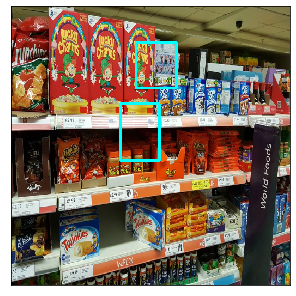

In [65]:
plot_result(1)

In [0]:
optimizer = torch.optim.SGD(dssd.parameters(), lr=1e-3, momentum=0.9)

epochs = 40
steps_per_epoch = 2
tot_len = X.shape[0]
batch_size = 2
loss = None
classification_loss = 0
regression_loss = 0
best_loss = 1
for j in range(epochs):
    for _ in range(steps_per_epoch):
        mat_boxes = None
        for i,ids in enumerate(get_batch_ids(tot_len, batch_size)):
            x = torch.Tensor(X[ids]).to(device)
            #y_labels = torch.Tensor(Y_labels[ids]).to(device)
            locs, confs = dssd.forward(x)
            classification_loss = 0.0
            regression_loss = 0.0

            for k in range(batch_size):
                ground_boxes = torch.Tensor(Y_annot[ids[k]]).to(device)
                reg_loss, cls_loss, mat_boxes = net_loss(ground_boxes, default_boxes, confs[k], locs[k])
                regression_loss += reg_loss
                classification_loss += cls_loss
            regression_loss /= batch_size
            classification_loss /= batch_size
            loss = regression_loss + classification_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) == batch_size:
                break

        if best_loss > loss:
            best_loss = loss
            torch.save(dssd, 'dssd.pth')

    print(f"Epoch : {j+1} ---------> Loss: {loss}, Classification Loss : {classification_loss.item()}, Regression Loss : {regression_loss.item()}")
    #plot_result(1)

In [0]:
torch.cuda.empty_cache()

In [0]:
#dssd = torch.load('dssd.pth', device)
#_ = dssd.eval()

In [0]:
torch.save(dssd, 'dssd_v2.pth')